# 第9回講義 演習

In [1]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 目次

課題1. Recurrent Neural Network (RNN) Encoder-Decoderモデルで英日翻訳
1. データセットの読み込みと単語・品詞のID化
2. 各層クラスの実装
3. 計算グラフ構築 & パラメータの更新設定
4. 学習
5. 生成

課題2. Attentionを用いた機械翻訳モデルの実装
1. Attention層の実装
2. 計算グラフ構築 & パラメータの更新設定
3. 学習
4. 生成

【補足】機械翻訳の評価について

【補足】Beam searchについて

## 課題1. Recurrent Neural Network (RNN) Encoder-Decoderモデルで英日翻訳

### 1. データセットの読み込みと単語・品詞のID化

今回はデータセットとして、英文とその日本語対訳がセットになった Tanaka Corpus ( http://www.edrdg.org/wiki/index.php/Tanaka_Corpus ) を使用します。

（厳密にはサイズの関係で、Tanaka Corpusの一部を抽出した https://github.com/odashi/small_parallel_enja を使っています。）

train.enとtrain.jaの中身は次のようになっています。

- train.enの中身 (英語の文)
```
i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
︙
```

- train.jaの中身(日本語の文、対訳)
```
誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
︙
```

この通り、そのまま読み込むと単語のまま読み込まれます。

これでは計算的には扱いづらいので、それぞれの単語を**数字によるIDに置き換え**ましょう。

この数値化には、`keras.preprocessing.text`の`Tokenizer`を用います。（割り当ては1からなので、0はpaddingに使用できます。）

ここではTokenizerの仕様については深く立ち入りませんので、気になる方は公式ドキュメントをチェックしてください。

なお、読み込む際には

- 文頭を表す仮想単語（**BOS**, Beginning Of Sentence）として`<s>`

- 文末を表す仮想単語（**EOS**, End Of Sentence）として`</s>`
    
を付加します。

参考：https://keras.io/ja/preprocessing/text/#tokenizer

In [2]:
def load_data(file_path, num_words=None):
    tokenizer = Tokenizer(num_words, filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

In [3]:
# 読み込み＆Tokenizerによる数値化
pad_index = 0
x_train, tokenizer_en = load_data('/root/userspace/public/chap09/data/train.en')
t_train, tokenizer_ja = load_data('/root/userspace/public/chap09/data/train.ja')

detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

en_vocab_size = len(tokenizer_en.word_index) + 1
ja_vocab_size = len(tokenizer_ja.word_index) + 1

x_train, _, t_train, _ = train_test_split(x_train, t_train, test_size=0.5, random_state=42) # 演習用に縮小
x_train, x_test, t_train, t_test = train_test_split(x_train, t_train, test_size=0.02, random_state=42)
x_train, x_valid, t_train, t_valid = train_test_split(x_train, t_train, test_size=0.02, random_state=42)

また、後ほど学習結果の確認で利用するため、複数の系列の中から`num`番目の系列をBOSとEOSを除いた上で取得する関数を定義しておきましょう。

In [4]:
bos_id_ja, eos_id_ja = tokenizer_ja.texts_to_sequences(['<s> </s>'])[0]

def get_raw_contents(dataset, num, bos_id, eos_id):
    result = []
    for index in dataset[num]:
        if index == eos_id:
            break
            
        result.append(index)
        
        if index == bos_id:
            result = []
            
    return result

In [5]:
def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

### 2. 各層クラスの実装

#### 2.1. Embedding層

実際にEmbedding層の処理を担うembedding_lookupでは、入力をone_hotベクトルに変換し、Embedding層の行列に掛け、対応する列ベクトルを選択します。
![embedding](../figures/embedding.png)

$$m:\text{emb_dim}, \ n : \text{vocab_size}$$

In [6]:
class Embedding:
    def __init__(self, vocab_size, emb_dim, scale=0.08):
        self.V = tf.Variable(tf.random_normal([vocab_size, emb_dim], stddev=scale), name='V')

    def __call__(self, x):
        return tf.nn.embedding_lookup(self.V, x)

#### 2.2. Long short-term memory (LSTM)

Encoder-Decoderモデルでは系列対系列の関係を扱うため、新たに状態の出力、系列での出力に対応させる必要があります。

また、生成を行う際には1ステップずつ逐次的にLSTMを実行したいので、状態を保持する機能も持たせましょう。

In [7]:
class LSTM:
    def __init__(self, hid_dim, seq_len, initial_state, return_state = False, return_sequences = False, hold_state = False, name = None):
        self.cell = tf.nn.rnn_cell.BasicLSTMCell(hid_dim)
        self.initial_state = initial_state
        self.seq_len = seq_len
        self.return_state = return_state
        self.return_sequences = return_sequences
        self.hold_state = hold_state
        self.name = name

    def __call__(self, x):
        with tf.variable_scope(self.name):
            outputs, state = tf.nn.dynamic_rnn(self.cell, x, self.seq_len, self.initial_state)
        
        if self.hold_state:
            self.initial_state = state
        
        if not self.return_sequences:
            outputs = state.h
            
        if not self.return_state:
            return outputs
        
        return outputs, state

### 3. 計算グラフ構築 & パラメータの更新設定

今回は以下のようなモデルを実装してみましょう。（ここでは、図中の`hidden layer 2`は省略します。）

<img src="../figures/seq2seq.png" width="50%">

引用：https://github.com/tensorflow/nmt

モデルの構造としては、

- 翻訳したい文をRNNで状態ベクトルによる表現に変換する（**Encoder**）
- 上述の状態ベクトルを考慮しつつ、**訳文の1単語先を予測**する（**Decoder**）

という大きく2つの部分からなっています。

学習タスクとしては、訳文の時点$t$の単語から時点$t+1$の単語の予測タスクとなっていますが、翻訳前の文章も考慮するわけです。

なお、誤差関数は多クラス交差エントロピーで、具体的には次のようになります。（ミニバッチサイズ：$N$、系列長：$T$、辞書サイズ：$K$）

$$
    \mathrm{E}\left(\{\boldsymbol{S}^{(n)}\}_{n=1,\ldots,N},\{\boldsymbol{Y}^{(n)}\}_{n=1,\ldots,N}\right) = -\frac{1}{N}\sum^N_{n=1}\sum^T_{t=1}\sum^K_{k=1} s^{(n)}_{t, k} \log y^{(n)}_{t, k}
$$
$$\left(\boldsymbol{S}^{(n)} = [\boldsymbol{s}^{(n)}_1\ \ \boldsymbol{s}^{(n)}_2\ \ \cdots \ \ \boldsymbol{s}^{(n)}_T]\in\{0,1\}^{K \times T},\ \ \boldsymbol{Y}^{(n)} = [\boldsymbol{y}^{(n)}_1\ \ \boldsymbol{y}^{(n)}_2\ \ \cdots \ \ \boldsymbol{y}^{(n)}_T]\in\mathbb{R}^{K \times T}\ \ \ n=1,2,\ldots,N\right)$$

$\boldsymbol{s}^{(n)}_t$は$n$番目の系列の時点$t$での単語のone_hot表現です。

また、各$\boldsymbol{y}^{(n)}_t$はモデルからの出力なので、モデルのパラメータ$\boldsymbol{\theta}$に依存しており, 最適化はこの$\boldsymbol{\theta}$について行われます。

#### paddingへの対処

Encoderへの入力（図中`source input words`）、Decoderへの入力（図中`target input words`）の双方で、短い系列にはpaddingを施して入力します。

そこで、EncoderについてはLSTM内でマスク処理を行います。

またDecoderでは、padding部分についてはコストが0になるようにします。

これは単語がある部分を1、paddingの部分を0とするバイナリのマスクをかけるか、paddingの部分の教師ラベルdの要素をすべて0になるようにします。

以下では後者の方法で実装していきます。

In [8]:
tf.reset_default_graph() # グラフ初期化

emb_dim = 256
hid_dim = 256

x = tf.placeholder(tf.int32, [None, None], name='x')
seq_len = tf.reduce_sum(tf.cast(tf.not_equal(x, pad_index), tf.int32), axis=1)
t = tf.placeholder(tf.int32, [None, None], name='t')
seq_len_t_in = tf.reduce_sum(tf.cast(tf.not_equal(t, pad_index), tf.int32), axis=1) - 1

t_out = tf.one_hot(t[:, 1:], depth=ja_vocab_size, dtype=tf.float32)
t_out = t_out * tf.expand_dims(tf.cast(tf.not_equal(t[:, 1:], pad_index), tf.float32), axis=-1)

initial_state = tf.nn.rnn_cell.LSTMStateTuple(tf.zeros([tf.shape(x)[0], hid_dim]), tf.zeros([tf.shape(x)[0], hid_dim]))

# Encoder
h_e = Embedding(en_vocab_size, emb_dim)(x)
_, encoded_state = LSTM(hid_dim, seq_len, initial_state, return_state=True, name='encoder_lstm')(h_e)

# Decoder
decoder = [
    Embedding(ja_vocab_size, emb_dim),
    LSTM(hid_dim, seq_len_t_in, encoded_state, return_sequences=True, name='decoder_lstm'),
    tf.layers.Dense(ja_vocab_size, tf.nn.softmax)
] # 生成時に再利用するためにモデルの各レイヤーを配列で確保

# Decoderに変数を通す
h_d = decoder[0](t)
h_d = decoder[1](h_d)
y = decoder[2](h_d)

cost = -tf.reduce_mean(tf.reduce_sum(t_out * tf_log(y[:, :-1]), axis=[1, 2]))

train = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


### 4. 学習

In [9]:
x_train_lens = [len(com) for com in x_train]
sorted_train_indexes = sorted(range(len(x_train_lens)), key=lambda x: -x_train_lens[x])

x_train = [x_train[ind] for ind in sorted_train_indexes]
t_train = [t_train[ind] for ind in sorted_train_indexes]

In [10]:
n_epochs = 10
batch_size = 128
n_batches = len(x_train) // batch_size

sess = tf.Session()

sess.run(tf.global_variables_initializer())
for epoch in range(n_epochs):
    # train
    train_costs = []
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        x_train_batch = np.array(pad_sequences(x_train[start:end], padding='post', value=pad_index))
        t_train_batch = np.array(pad_sequences(t_train[start:end], padding='post', value=pad_index))

        _, train_cost = sess.run([train, cost], feed_dict={x: x_train_batch, t: t_train_batch})
        train_costs.append(train_cost)

    # valid
    x_valid_pad = np.array(pad_sequences(x_valid, padding='post', value=pad_index))
    t_valid_pad = np.array(pad_sequences(t_valid, padding='post', value=pad_index))

    valid_cost = sess.run(cost, feed_dict={x: x_valid_pad, t: t_valid_pad})
    print('EPOCH: %i, Training Cost: %.3f, Validation Cost: %.3f' % (epoch+1, np.mean(train_costs), valid_cost))

EPOCH: 1, Training Cost: 60.915, Validation Cost: 52.647
EPOCH: 2, Training Cost: 45.586, Validation Cost: 42.713
EPOCH: 3, Training Cost: 39.473, Validation Cost: 38.896
EPOCH: 4, Training Cost: 36.225, Validation Cost: 36.890
EPOCH: 5, Training Cost: 33.947, Validation Cost: 35.413
EPOCH: 6, Training Cost: 32.075, Validation Cost: 34.094
EPOCH: 7, Training Cost: 30.413, Validation Cost: 33.037
EPOCH: 8, Training Cost: 28.881, Validation Cost: 32.030
EPOCH: 9, Training Cost: 27.403, Validation Cost: 31.049
EPOCH: 10, Training Cost: 26.015, Validation Cost: 30.259


### 5. 生成

翻訳文の生成には、先程学習したDecoderモデルに対して、1単語ずつ文末まで繰り返し後続単語の予測を行う必要があります。

この繰り返しに`while`ループを使うので、まず`tf`におけるwhileループの実装である`tf.while_loop`について見ていきましょう。

####  5.1. `tf.while_loop`関数  \[[link](https://www.tensorflow.org/api_docs/python/tf/while_loop)\]

主な引数は以下のとおりです。

- 第1引数 `cond`: `True` or `False` を返す関数 (正確にはcallable)
- 第2引数 `body`: 各iterationで実行する関数 (正確にはcallable)
- 第3引数 `loop_vars`: `cond`及び`body`に最初に渡される変数

`cond`で指定された関数の戻り値が`True`である限り`body`で指定された関数を実行し続けます。

そして、`loop_vars`で指定された全ての変数に対して、最後のiteration後の値を返します。

例えば、入力が5未満であるかぎり1ずつ足す処理を実行したい場合、コードは次のようになります。

In [11]:
g0 = tf.Graph() # Encoder-Decoderモデルのグラフと区別するために新しいグラフオブジェクトを作成

def cond(z):
    return z < 5

def body(z):
    return z + 1

with g0.as_default():
    z = tf.constant(0)

    res = tf.while_loop(cond, body, [z])

with tf.Session(graph=g0) as sess_g0:
    print(sess_g0.run(res))

5


また、`tf.while_loop`の各iteration後の変数の`shape`はデフォルトでは同じであることが指定されています。

したがって、各iteration後の`shape`が変化する場合は、この条件を緩和する必要があります。

例えば、上の1ずつ足すプログラムですべてのiteration後の値を保持して返したい場合、各iterationの戻り値は

```
[1], [1, 2], [1, 2, 3], [1, 2, 3, 4], ...
```
となっていくので、それぞれの`shape`は
```
(1,), (2,), (3,), (4,), ...
```
と変化していきます。

つまり、この例ではベクトルの次元数が変化していくので、`shape_invariants`で`shape`を`[None]` (実際は`tf.TensorShape([None])`と指定します。

具体的なコードは次のようになります。

In [12]:
g1 = tf.Graph() # Encoder-Decoderモデルのグラフと区別するために新しいグラフオブジェクトを作成

def cond(z):
    return z[-1] < 5

def body(z):
    return tf.concat([z, z[-1:]+1], axis=0)

with g1.as_default():
    z = tf.zeros(1)

    res = tf.while_loop(
        cond,
        body,
        [z],
        shape_invariants=[tf.TensorShape([None])]
    )

with tf.Session(graph=g1) as sess_g1:
    print(sess_g1.run(res))

[0. 1. 2. 3. 4. 5.]


2x1行列に対して同じような操作をしたい場合は次のようになります。この場合各iteration後の行列の`shape`は
```
(2, 1), (2, 2), (2, 3), (2, 4), ...
```
と列数のみ変化していくので、`shape_invariants`には`tf.TensorShape([2, None])`と指定します。

In [13]:
g2 = tf.Graph() # Encoder-Decoderモデルのグラフと区別するために新しいグラフオブジェクトを作成


def cond(z):
    return tf.reduce_sum(z[:, -1]) < 5*2

def body(z):
    return tf.concat([z, z[:, -1:]+1], axis=1)

with g2.as_default():
    z = tf.zeros([2, 1])

    res = tf.while_loop(
        cond,
        body,
        [z],
        shape_invariants=[tf.TensorShape([2, None])]
    )

with tf.Session(graph=g2) as sess_g2:
    print(sess_g2.run(res))

[[0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]]


詳細は公式のドキュメントを参照してください。

- tf.while_loop: https://www.tensorflow.org/api_docs/python/tf/while_loop

#### 5.2. グラフの構築

未知の入力に対してEncoder-Decoderモデルを適用するとき、正解ラベル$d$はわかりません。

そこで、代わりに前のステップで予測した単語を各ステップでの入力とします。そして、系列の終わりを表す単語 (`</s>`) が出力されるまで繰り返します。

具体的には、$\boldsymbol{h}_{t-1}, \boldsymbol{c}_{t-1}, \boldsymbol{y}_{t-1}$を入力として$\boldsymbol{y}_t$を受け取る操作を、バッチ内の全てのサンプルにおける$\boldsymbol{y}_t$が`</s>`となるまで続けます。

なお、各ステップで順伝播後の`decorder_lstm`の`state`を取得したいので、`decorder_lstm`の`hold_state`をオンにします。

In [14]:
bos_eos = tf.placeholder(tf.int32, [2], name='bos_eos')
max_len = tf.placeholder(tf.int32, name='max_len') # iterationの繰り返し回数の限度

def cond(t, continue_flag, init_state, seq_last, seq):
    unfinished = tf.not_equal(tf.reduce_sum(tf.cast(continue_flag, tf.int32)), 0)
    return tf.logical_and(t < max_len, unfinished)

def body(t, prev_continue_flag, init_state, seq_last, seq):
    decoder[1].initial_state = init_state
    
    # Decoderの再構築
    h = decoder[0](tf.expand_dims(seq_last, axis=-1))
    h = decoder[1](h)
    y = decoder[2](h)
    
    seq_t = tf.reshape(tf.cast(tf.argmax(y, axis=2), tf.int32), shape=[-1])
    next_state = decoder[1].initial_state
    
    continue_flag = tf.logical_and(prev_continue_flag, tf.not_equal(seq_t, bos_eos[1])) # flagの更新

    return [t+1, continue_flag, next_state, seq_t, seq.write(t, seq_t)]

In [15]:
decoder[1].hold_state = True
decoder[1].seq_len = None

seq_0 = tf.ones([tf.shape(x)[0]], tf.int32)*bos_eos[0]

t_0 = tf.constant(1)
f_0 = tf.cast(tf.ones_like(seq_0), dtype=tf.bool) # バッチ内の各系列で</s>が出たかどうかの未了flag(0:出た, 1:出てない)
seq_array = tf.TensorArray(dtype=tf.int32, size=1, dynamic_size=True).write(0, seq_0)

*_, seq = tf.while_loop(cond, body, loop_vars=[t_0, f_0, encoded_state, seq_0, seq_array])

res = tf.transpose(seq.stack())

#### 5.3. 生成

In [16]:
y_pred = sess.run(res, feed_dict={
    x: pad_sequences(x_test, padding='post', value=pad_index),
    bos_eos: np.array([bos_id_ja, eos_id_ja]),
    max_len: 100
})

#### 5.4. 生成例

In [17]:
num = 0
pred = get_raw_contents(y_pred, num, bos_id_ja, eos_id_ja)

print('元の文:', ' '.join([detokenizer_en[com] for com in x_test[num][1:-1]]))
print('生成文:', ' '.join([detokenizer_ja[com] for com in pred]))
print('正解文:', ' '.join([detokenizer_ja[com] for com in t_test[num][1:-1]]))

元の文: i think this book is easy .
生成文: この 本 は 私 の こと が 好き で す か 。
正解文: 私 は この 本 は やさし い と 思 う 。


## 課題2. Attentionを用いた機械翻訳モデルの実装

### 1. Attention層の実装

今回は Luong et al., 2015のGlobal attentionモデルを実装します。

- "Effective Approaches to Attention-based Neural Machine Translation", Minh-Thang Luong et al., EMNLP 2015 https://arxiv.org/abs/1508.04025

課題1で実装したモデルは左図、ここで実装するモデルは右図になります。

<img src="../figures/attention-1.png" width="1000mm">

#### Decoderの各ステップにおける計算の手順

Encoderの各ステップの隠れ層を

$$
    \boldsymbol{\bar{h}} = \{\boldsymbol{\bar{h}}_1, \boldsymbol{\bar{h}}_2, \ldots, \boldsymbol{\bar{h}}_s, \ldots, \boldsymbol{\bar{h}}_S\}
$$

Decoderの各ステップの隠れ層を

$$
    \boldsymbol{h} = \{\boldsymbol{h}_1, \boldsymbol{h}_2, \ldots, \boldsymbol{h}_t, \ldots, \boldsymbol{h}_T\}
$$

とします。

Attention Layerの計算手順は以下のようになります。

1. Decoderの各時点の出力に対して、入力系列のどのステップに注目するかを表すscore関数の値を計算します。
$$
   \mathrm{score}\left(\boldsymbol{\bar{h}}_s,\ \boldsymbol{h}_t\right) = \boldsymbol{h}_t^{\mathrm{T}} \boldsymbol{W}_a \boldsymbol{\bar{h}}_s
$$
なお、score関数には任意性があり、今回用いる関数以外にも例えば以下の様なものが提案されています。
$$
\mathrm{score}\left(\boldsymbol{\bar{h}}_s,\ \boldsymbol{h}_t\right) =
\begin{cases}
    {\boldsymbol{h}_t}^{\mathrm{T}} \boldsymbol{\bar{h}}_s \\
    \boldsymbol{v}^{\mathrm{T}} \tanh\left(\boldsymbol{W}_{ad} \boldsymbol{h}_t + \boldsymbol{W}_{ae} \boldsymbol{\bar{h}}_s\right)
\end{cases}
$$

2. 次にscoreをsoftmax関数により**重み**$\ \boldsymbol{a}_t(s)$に変換します。
$$
    \boldsymbol{a}_t(s) = \frac{\exp\left[\mathrm{score}\left(\boldsymbol{\bar{h}}_s,\ \boldsymbol{h}_t\right)\right]}{\sum^S_{s'=1}\exp\left[\mathrm{score}\left(\boldsymbol{\bar{h}}_s,\ \boldsymbol{h}_t\right)\right]}
$$
3. 2.で計算した重みを元に、Encoderの出力の加重平均ベクトル (**文脈ベクトル**) $\boldsymbol{c}_t$ を計算します。
$$
    \boldsymbol{c}_t = \sum^S_{s=1} \boldsymbol{a}_t(s) \boldsymbol{\bar{h}}_s
$$
4. 3.で計算した文脈ベクトル$\boldsymbol{c}_t$と元の出力$\boldsymbol{h}_t$から、新しい出力ベクトル$\boldsymbol{\tilde{h}}_t$を計算します。
$$
    \boldsymbol{\tilde{h}}_t = \tanh\left(\boldsymbol{W}_c \left[\begin{array}{c} \boldsymbol{c}_t \\ \boldsymbol{h}_t \end{array}\right] + \boldsymbol{b}\right)
$$

論文では$\boldsymbol{\tilde{h}}_t$が次のタイムステップのLSTMにfeedされる方法も示されており、他の論文でもそのようにしているものも多いです。

その場合、Attention層とLSTM層は分けずに、同じクラスで書くことになります。

#### Attentionのマスクについて

先程と同様、ミニバッチ化の際には短い系列に対してpaddingを行いますが、Encoderのpadding部分にはAttentionの適用も回避したいわけです。

そこで、padding部分は$\exp\left[\mathrm{score}\left(\boldsymbol{\bar{h}}_s,\ \boldsymbol{h}_t\right)\right]$ が0になるように (score関数の値がとても小さな値になるように) マスクをかけます。

In [18]:
class Attention:
    def __init__(self, hid_dim, out_dim, enc_out, seq_len):
        e_hid_dim, d_hid_dim = hid_dim, hid_dim
        
        self.enc_out = enc_out
        self.seq_len = seq_len
        glorot_a = tf.cast(tf.sqrt(6/(e_hid_dim + d_hid_dim)), tf.float32)
        self.W_a  = tf.Variable(tf.random_uniform([e_hid_dim, d_hid_dim], minval=-glorot_a, maxval=glorot_a), name='W_a')
        
        glorot_c = tf.cast(tf.sqrt(6/(e_hid_dim + d_hid_dim + out_dim)), tf.float32)
        self.W_c = tf.Variable(tf.random_uniform([e_hid_dim+d_hid_dim, out_dim], minval=-glorot_c, maxval=glorot_c), name='W_c')
        self.b    = tf.Variable(np.zeros([out_dim]).astype('float32'), name='b')
        
    def __call__(self, dec_out):
        # self.enc_out: [batch_size, enc_length, e_hid_dim]
        # self.W_a  : [e_hid_dim, d_hid_dim]
        # -> enc_out: [batch_size, enc_length, d_hid_dim]
        W_a_broadcasted = tf.tile(tf.expand_dims(self.W_a, axis=0), [tf.shape(self.enc_out)[0],1,1])
        enc_out = tf.matmul(self.enc_out, W_a_broadcasted)
        
        # dec_out: [batch_size, dec_length, d_hid_dim]
        # enc_out: [batch_size, enc_length, d_hid_dim]
        # -> score: [batch_size, dec_length, enc_length]
        score = tf.matmul(dec_out, tf.transpose(enc_out, perm=[0,2,1])) # Attention score
        
        # encoderのステップにそって正規化する
        score = score - tf.reduce_max(score, axis=-1, keep_dims=True) # for numerically stable softmax
        mask = tf.cast(tf.sequence_mask(self.seq_len, tf.shape(score)[-1]), tf.float32) # encoder mask
        exp_score = tf.exp(score) * tf.expand_dims(mask, axis=1)
        self.a = exp_score / tf.reduce_sum(exp_score, axis=-1, keep_dims=True) # softmax

        # self.a  : [batch_size, dec_length, enc_length]
        # self.enc_out: [batch_size, enc_length, e_hid_dim]
        # -> c: [batch_size, dec_length, e_hid_dim]
        c = tf.matmul(self.a, self.enc_out) # Context vector

        W_c_broadcasted = tf.tile(tf.expand_dims(self.W_c, axis=0), [tf.shape(c)[0],1,1])

        return tf.nn.tanh(tf.matmul(tf.concat([c, dec_out], -1), W_c_broadcasted) + self.b)

### 2. 計算グラフ構築 & パラメータの更新設定

In [19]:
tf.reset_default_graph() # グラフ初期化

emb_dim = 512
hid_dim = 256
att_dim = 128

x = tf.placeholder(tf.int32, [None, None], name='x')
seq_len = tf.reduce_sum(tf.cast(tf.not_equal(x, pad_index), tf.int32), axis=1)
t = tf.placeholder(tf.int32, [None, None], name='t')
seq_len_t_in = tf.reduce_sum(tf.cast(tf.not_equal(t, pad_index), tf.int32), axis=1) - 1

t_out = tf.one_hot(t[:, 1:], depth=ja_vocab_size, dtype=tf.float32)
t_out = t_out * tf.expand_dims(tf.cast(tf.not_equal(t[:, 1:], pad_index), tf.float32), axis=-1)

initial_state = tf.nn.rnn_cell.LSTMStateTuple(tf.zeros([tf.shape(x)[0], hid_dim]), tf.zeros([tf.shape(x)[0], hid_dim]))

# Encoder
h_e = Embedding(en_vocab_size, emb_dim)(x)
encoded_outputs, encoded_state = LSTM(hid_dim, seq_len, initial_state, return_sequences=True, return_state=True, name='encoder_lstm_a')(h_e)

# Decoder
decoder = [
    Embedding(ja_vocab_size, emb_dim),
    LSTM(hid_dim, seq_len_t_in, encoded_state, return_sequences=True, name='decoder_lstm_a'),
    Attention(hid_dim, att_dim, encoded_outputs, seq_len),
    tf.layers.Dense(ja_vocab_size, tf.nn.softmax)
] # 生成時に再利用するためにまとめて確保

h_d = decoder[0](t)
h_d = decoder[1](h_d)
h_d = decoder[2](h_d)
y = decoder[3](h_d)

cost = -tf.reduce_mean(tf.reduce_sum(t_out * tf_log(y[:, :-1]), axis=[1, 2]))

train = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### 3. 学習

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 15
batch_size = 128
n_batches_train = len(x_train)//batch_size
n_batches_valid = len(x_valid)//batch_size

for epoch in range(n_epochs):
    # Train
    train_costs = []
    for i in range(n_batches_train):
        start = i * batch_size
        end = start + batch_size
        
        x_train_batch = np.array(pad_sequences(x_train[start:end], padding='post', value=pad_index))
        t_train_batch = np.array(pad_sequences(t_train[start:end], padding='post', value=pad_index))
        
        _, train_cost = sess.run([train, cost], feed_dict={x: x_train_batch, t: t_train_batch})
        train_costs.append(train_cost)

    # Valid
    valid_costs = []
    for i in range(n_batches_valid):
        start = i * batch_size
        end = start + batch_size
        
        x_valid_pad = np.array(pad_sequences(x_valid[start:end], padding='post', value=pad_index))
        t_valid_pad = np.array(pad_sequences(t_valid[start:end], padding='post', value=pad_index))
        
        valid_cost = sess.run(cost, feed_dict={x: x_valid_pad, t: t_valid_pad})
        valid_costs.append(valid_cost)

    print('EPOCH: %i, Training Cost: %.3f, Validation Cost: %.3f' % (epoch+1, np.mean(train_costs), np.mean(valid_costs)))

EPOCH: 1, Training Cost: 66.897, Validation Cost: 62.826
EPOCH: 2, Training Cost: 62.346, Validation Cost: 62.408
EPOCH: 3, Training Cost: 60.912, Validation Cost: 60.312
EPOCH: 4, Training Cost: 55.124, Validation Cost: 48.460
EPOCH: 5, Training Cost: 43.232, Validation Cost: 40.750
EPOCH: 6, Training Cost: 37.957, Validation Cost: 37.580
EPOCH: 7, Training Cost: 34.963, Validation Cost: 35.596
EPOCH: 8, Training Cost: 32.674, Validation Cost: 34.060
EPOCH: 9, Training Cost: 30.733, Validation Cost: 32.887
EPOCH: 10, Training Cost: 29.012, Validation Cost: 31.831
EPOCH: 11, Training Cost: 27.438, Validation Cost: 30.712
EPOCH: 12, Training Cost: 25.951, Validation Cost: 30.008
EPOCH: 13, Training Cost: 24.427, Validation Cost: 29.420
EPOCH: 14, Training Cost: 22.902, Validation Cost: 28.872
EPOCH: 15, Training Cost: 21.443, Validation Cost: 28.537


### 4. 翻訳文の生成とattention weightの可視化

#### 4.1. グラフの構築

In [21]:
bos_eos = tf.placeholder(tf.int32, [2], name='bos_eos')
max_len = tf.placeholder(tf.int32, name='max_len') # iterationの繰り返し回数の限度

def cond(t, continue_flag, init_state, seq_last, seq, att):
    unfinished = tf.not_equal(tf.reduce_sum(tf.cast(continue_flag, tf.int32)), 0)
    return tf.logical_and(t < max_len, unfinished)

def body(t, prev_continue_flag, init_state, seq_last, seq, att):
    decoder[1].initial_state = init_state
    
    # Decoderグラフを再構築
    h = decoder[0](tf.expand_dims(seq_last, -1))
    h = decoder[1](h)
    h = decoder[2](h)
    y = decoder[3](h)
    
    seq_t = tf.reshape(tf.cast(tf.argmax(y, axis=2), tf.int32), shape=[-1])
    next_state = decoder[1].initial_state
    
    continue_flag = tf.logical_and(prev_continue_flag, tf.not_equal(seq_t, bos_eos[1])) # flagの更新

    return [t+1, continue_flag, next_state, seq_t, seq.write(t, seq_t), att.write(t-1, tf.squeeze(decoder[2].a))]

In [22]:
decoder[1].hold_state = True
decoder[1].seq_len = None

seq_0 = tf.ones([tf.shape(x)[0]], tf.int32)*bos_eos[0]

t_0 = tf.constant(1)
f_0 = tf.cast(tf.ones_like(seq_0), dtype=tf.bool) # バッチ内の各系列で</s>が出たかどうかの未了flag(0:出た, 1:出てない)
seq_array = tf.TensorArray(dtype=tf.int32, size=1, dynamic_size=True).write(0, seq_0)
att_array = tf.TensorArray(dtype=tf.float32, size=1, dynamic_size=True)

*_, seq, att = tf.while_loop(cond, body, loop_vars=[t_0, f_0, encoded_state, seq_0, seq_array, att_array])

res = (tf.transpose(seq.stack()), tf.transpose(att.stack(), perm=[1, 0, 2]))

#### 4.2. 生成

In [23]:
y_pred, att_weights = sess.run(res, feed_dict={
    x: pad_sequences(x_test, padding='post', value=pad_index),
    bos_eos: np.array([bos_id_ja, eos_id_ja]),
    max_len: 100
})

#### 4.3. 生成例

In [24]:
num = 0

pred = get_raw_contents(y_pred, num, bos_id_ja, eos_id_ja)

print('元の文:', ' '.join([detokenizer_en[com] for com in x_test[num][1:-1]]))
print('生成文:', ' '.join([detokenizer_ja[com] for com in pred]))
print('正解文:', ' '.join([detokenizer_ja[com] for com in t_test[num][1:-1]]))

元の文: i think this book is easy .
生成文: 私 は この 本 が 好き で す 。
正解文: 私 は この 本 は やさし い と 思 う 。


#### 4.4. アテンションの可視化

`matplotlib`でアテンションを可視化してみましょう。

具体的には訳文の生成に当たって、原文のどの単語をどれだけ重視したかをヒートマップで表示します。

まず、`matplotlib`はデフォルトでは日本語が文字化けしてしまうので、日本語フォントのインストールを行います。

今回はTakaoフォント (https://launchpad.net/takao-fonts) を利用します。

In [ ]:
%%bash
rm ~/.cache/matplotlib/fontlist-v300.json
wget -q https://s3.amazonaws.com/ilect-public/ail/TakaoPGothic.ttf
mv TakaoPGothic.ttf /usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/fonts/ttf/

アテンションで獲得した重み$a = [\boldsymbol{a}_1(s)\ \ \boldsymbol{a}_2(s)\ \ \cdots\ \ \boldsymbol{a}_T(s)]$を可視化してみます。

縦軸に訳文、横軸に原文を表示し、重みをヒートマップで表示します。

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


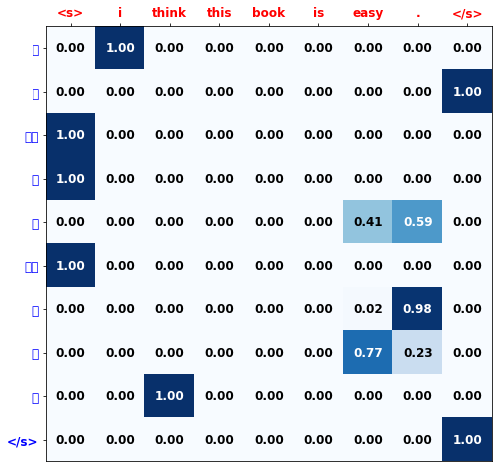

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

# BOSは生成したものでないので除外されることに注意
pred = get_raw_contents(y_pred, num, bos_id_ja, eos_id_ja) + [eos_id_ja]

# アテンションの重み
attention = att_weights[num][:len(pred), :len(x_test[num])]

# 軸ラベル（x：原文、y：訳文）
xticks = [detokenizer_en[com] for com in x_test[num]]
yticks = [detokenizer_ja[com] for com in pred]

# figure & axes の生成
fig, ax = plt.subplots(figsize=(8, 8))

# ヒートマップの作製
ax.pcolor(attention, cmap=plt.cm.Blues)

# 重みの値を表示
for (cord_y, cord_x), w in np.ndenumerate(attention):
    ax.annotate(format(w, '.2f'), xy=(cord_x+0.5, cord_y+0.5), ha='center', va='center',
                fontsize=12, color=str(round(w)), fontweight='bold')

# 軸の調整（メモリ位置、軸の向き・配置・ラベル）
ax.set_xticks(np.arange(attention.shape[1]) + 0.5)
ax.set_yticks(np.arange(attention.shape[0]) + 0.5)

ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(xticks, fontsize=12, color='r', fontweight='bold')
ax.set_yticklabels(yticks, fontsize=12, color='b', fontweight='bold', fontdict={'family': 'TakaoPGothic'})

plt.show()

## 【補足】機械翻訳の評価について

これまで、基本的に学習したモデルの良し悪しについては損失をベースに考えてきました。

ですが機械翻訳の場合、損失と翻訳の精度が必ずしも一致しません。

というのも、翻訳においては、単純に各単語が一致しているか否か以上に、意味的な繋がりや表現の流暢さが重要となるためです。

また、必ずしも語順についても一致している必要はありません。

そこで、そうした翻訳タスク特有の性質を反映した評価指標が必要となります。その代表例として、**BLEUスコア**が挙げられます。

BLEUスコアは、n-gram（連続n単語、主にn=4）がどれだけ生成文と正解文で共有されているかなどを考慮した指標となっています。

詳細な算出方法等に興味がある方はスクリプト ( http://www.nltk.org/_modules/nltk/translate/bleu_score.html ) をのぞいてみてください。

In [26]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

prediction = ['I', 'am', 'a', 'graduate', 'student', 'at', 'a', 'university']
reference = [['I', 'am', 'a', 'graduate', 'student', 'at', 'the', 'university', 'of', 'tokyo']]

print(sentence_bleu(reference, prediction))

0.5506953149031837


In [27]:
num = 0

gen = [detokenizer_ja[com] for com in get_raw_contents(y_pred, num, bos_id_ja, eos_id_ja)]
ref = [detokenizer_ja[com] for com in t_valid[num][1:-1]]

print(gen)
print(ref)

print(sentence_bleu(ref, gen, smoothing_function=SmoothingFunction().method1))

['私', 'は', 'この', '本', 'が', '好き', 'で', 'す', '。']
['戻', 'っ', 'て', 'お', 'い', 'で', '戻', 'っ', 'て', 'お', 'い', 'で', 'よ', '。']
0.028517539529041507


## 【補足】Beam searchについて

ここまで生成については、常に各時点で最大の確率を持つ単語を選択していました。（貪欲法）

ですが、これは局所的（各時点）には最適であっても、大域的（生成した系列全体）に見て最適とは限りません。

とはいえ、大域的に最適な系列を生成するには、各時点で全候補（正の確率を持つ全単語）を列挙し、その全候補に対して再び生成を行う必要があります。

すなわち、単語集合$\mathcal{V}$、系列長$T$のとき大雑把に言えば$|\mathcal{V}|^T$通りの系列を生成する必要があり、とても現実的ではありません。

そこでこの全列挙とこれまでの貪欲法の中間を考えることで、現実的な計算時間でより大域的な評価を考慮に入れた生成が可能になります。

この手法を**Beam search**と呼びます。内容としては、各時点で上位$K$個だけの候補を残しながら系列を生成するという単純なものです。

以下に参考までにBeam searchによる生成部分のコードを記載しておきます。

In [28]:
K = 3

bos_eos = tf.placeholder(tf.int32, [2], name='bos_eos')
max_len = tf.placeholder(tf.int32, name='max_len') # iterationの繰り返し回数の限度

def batch_gather(param, index):
    if index.shape.ndims == 1:
        return tf.gather_nd(param, tf.expand_dims(index, axis=-1))
    batch_index = tf.expand_dims(tf.tile(tf.expand_dims(tf.range(tf.shape(index)[0]), axis=-1), [1,tf.shape(index)[1]]), axis=-1)
    gather_index = tf.concat([batch_index, tf.expand_dims(index, axis=-1)], axis=-1)
    return tf.gather_nd(param, gather_index)
    
# beam search用ループ関数 (系列長方向へのループ)
def cond(t, continue_flag, init_state, seq_last, cum_ll, seq, ll, link):
    unfinished = tf.not_equal(tf.reduce_sum(tf.cast(continue_flag, tf.int32)), 0)
    return tf.logical_and(t+1 < max_len, unfinished)

def body(t, prev_continue_flag, init_state, seq_last, cum_ll, seq, ll, link):
    # beam search用ループ関数 (top_k候補方向へのループ)
    def inner_cond(k, init_state, seq_last, cand_ll, cand_ids, next_state):
        return k < K
    
    def inner_body(k, init_state, seq_last, cand_ll, cand_ids, next_state):
        decoder[1].initial_state = tf.nn.rnn_cell.LSTMStateTuple(init_state[k][0], init_state[k][1])
    
        # Decoderグラフを再構築
        h = decoder[0](tf.expand_dims(seq_last[:,k], axis=-1))
        h = decoder[1](h)
        h = decoder[2](h)
        y = decoder[3](h)
        
        # 直前の各top_K候補に対してtop_Kだけ現時点の候補を残すようスクリーニング
        cand_ll_k, cand_ids_k = tf.nn.top_k(tf.log(tf.reshape(y, shape=[tf.shape(x)[0],-1])), k=K)
        
        cand_ll_k = tf.expand_dims(cand_ll_k, axis=0)
        cand_ids_k = tf.expand_dims(cand_ids_k, axis=0)
        state = tf.expand_dims(decoder[1].initial_state, axis=0)
        
        # 記録
        indices = tf.eye(K, dtype=tf.int32)[k]
        cand_ll += batch_gather(tf.concat([tf.zeros_like(cand_ll_k), cand_ll_k], axis=0), indices)
        cand_ids += batch_gather(tf.concat([tf.zeros_like(cand_ids_k), cand_ids_k], axis=0), indices)
        next_state += batch_gather(tf.concat([tf.zeros_like(state), state], axis=0), indices)
        
        return [k+1, init_state, seq_last, cand_ll, cand_ids, next_state]
    
    # top_K方向へのループの構築
    cand_ll = tf.zeros([K, tf.shape(seq_last)[0], K], tf.float32) # [prev_top_K, batch_size, current_top_K]
    cand_ids = tf.zeros([K, tf.shape(seq_last)[0], K], tf.int32)
    next_state = tf.zeros_like(init_state)
    
    *_, cand_ll, cand_ids, next_state = tf.while_loop(inner_cond, inner_body, loop_vars=[tf.constant(0), init_state, seq_last, cand_ll, cand_ids, next_state])

    # K-majorからbatch-majorに
    cand_ll = tf.transpose(cand_ll, perm=[1, 0, 2])
    cand_ids = tf.transpose(cand_ids, perm=[1, 0, 2])
    
    # </s>以降に対するマスクの適用
    mask = tf.expand_dims(tf.cast(prev_continue_flag, tf.int32), axis=-1)
    cand_ll = cand_ll * tf.cast(mask, tf.float32)
    cand_ids = cand_ids * mask - (1-mask)
    
    # 累積尤度へ変換
    cand_cum_ll = cand_ll + tf.expand_dims(cum_ll, axis=-1)
    
    # 現時点でのtop_Kの決定
    top_k_cum_ll, top_k_place = tf.nn.top_k(tf.reshape(cand_cum_ll, shape=[-1, K*K]), k=K) # [batch_size, K*K]
    
    # top_Kの情報出力 (id、対数尤度、直前のid：後者2つは後ほど可視化に利用)
    seq_t = batch_gather(tf.reshape(cand_ids, shape=[-1, K*K]), top_k_place)
    seq_t_ll = batch_gather(tf.reshape(cand_ll, shape=[-1, K*K]), top_k_place)
    seq_t_prev = tf.floordiv(top_k_place, K) # [batch_size, top_K]:各要素はprev_state
    
    # 次時点の初期状態の選定
    next_state = tf.transpose(next_state, perm=[2, 0, 1, 3]) # [prev_state, lstm_state_type, batch_size, hid_dim] -> [batch_size, prev_state, lstm_state_type, hid_dim]
    next_state = batch_gather(next_state, seq_t_prev)
    next_state = tf.transpose(next_state, perm=[1, 2, 0, 3])
    
    # flagの更新
    continue_flag = tf.logical_and(prev_continue_flag, tf.not_equal(seq_t, bos_eos[1]))

    return [t+1, continue_flag, next_state, seq_t, top_k_cum_ll,
            seq.write(t, seq_t), ll.write(t, seq_t_ll), link.write(t, seq_t_prev)]

decoder[1].hold_state = True
decoder[1].seq_len = None

# 初期値生成
batch_size = tf.shape(x)[0]
seq_0 = tf.ones([batch_size], tf.int32)*bos_eos[0]
decoder[1].initial_state = encoded_state

h = decoder[0](tf.expand_dims(seq_0, axis=-1))
h = decoder[1](h)
h = decoder[2](h)
y = decoder[3](h)

cum_ll_0, seq_0 = tf.nn.top_k(tf.log(tf.reshape(y, shape=[batch_size,-1])), k=K)
init_state = tf.tile(tf.expand_dims(decoder[1].initial_state, axis=0), [K,1,1,1])

t_0 = tf.constant(1)
f_0 = tf.cast(tf.ones_like(seq_0), dtype=tf.bool) # バッチ内の各系列で</s>が出たかどうかの未了flag(0:出た, 1:出てない)
seq_array = tf.TensorArray(dtype=tf.int32, size=1, dynamic_size=True).write(0, seq_0)
ll_array = tf.TensorArray(dtype=tf.float32, size=1, dynamic_size=True).write(0, cum_ll_0)
link_array = tf.TensorArray(dtype=tf.int32, size=1, dynamic_size=True).write(0, tf.zeros([batch_size, K], tf.int32))

# beam searchループ構築
*_, seq, ll, link = tf.while_loop(cond, body, loop_vars=[t_0, f_0, init_state, seq_0, cum_ll_0, seq_array, ll_array, link_array])

# 結果出力（TensorArrayのTensorへの変換）
res = (tf.transpose(seq.stack(), perm=[1, 0, 2]), tf.transpose(ll.stack(), perm=[1, 0, 2]), tf.transpose(link.stack(), perm=[1, 0, 2]))

In [29]:
y_pred, ll, link = sess.run(res, feed_dict={
    x: pad_sequences(x_test, padding='post', value=pad_index),
    bos_eos: np.array([bos_id_ja, eos_id_ja]),
    max_len: 100
})

生成結果は以下のようにしてグラフで可視化できます。

赤いノードの系列が最適な生成と予想されたものになります。

（以下のコードでnx.nx_agraph.graphviz_layoutによって表示する場合には別途PyGraphvizのインストールが必要です）

In [30]:
def rest_rows(G, root, result = None):
    if result is None:
        result = {}

    result[root] = sum([rest_rows(G, node, result)[node] for node in G.successors(root)])
    if result[root] == 0:
        result[root] = 1

    return result

def hierarchy_pos(G, root, coord = (0, 0.5), y_offset = 0, height=1., dx = 0.2, pos = None):
    rows = rest_rows(G, root)
    
    if pos is None:
        pos = {root:coord}
    else:
        pos[root] = coord
        
    for node in G.successors(root):
        new_height = rows[node]*height/rows[root]
        new_coord = (coord[0] + dx, y_offset + new_height/2)
        pos = hierarchy_pos(G, node, new_coord, y_offset, new_height, dx, pos=pos)
        y_offset += new_height
    
    return pos

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

def parse_beam_search(pred, ll, link):
    G = nx.DiGraph()
    
    G.add_node((0, 0), label=detokenizer_ja[bos_id_ja], weight=0)
    for t in range(len(pred)):
        for k in range(K):
            prev_node = (t, link[t,k])
            if (prev_node not in G) or (G.nodes[prev_node]['label'] == detokenizer_ja[eos_id_ja]):
                continue
            G.add_node((t+1, k), label=detokenizer_ja[pred[t,k]], weight=G.nodes[prev_node]['weight']+ll[t,k])
            G.add_edge(prev_node, (t+1, k), weight=ll[t, k], label=ll[t, k])
    
    pos = hierarchy_pos(G, (0, 0))
    #pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args="-Grankdir=LR")
    
    leaf = [v for v, l in G.nodes(data='label') if l == detokenizer_ja[eos_id_ja]]
    leaf = {v: G.nodes[v]['weight'] for v in leaf}
    path = nx.shortest_path(G, source=(0, 0), target=sorted(leaf.items(), key=lambda x: -x[1])[0][0])

    plt.figure(figsize=(20,10))
    node_size = 700
    
    # nodes
    nx.draw_networkx_nodes(G, pos, nodelist=[v for v in G.nodes if v not in path], node_color='c', node_size=node_size)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='r', node_size=node_size)
    nx.draw_networkx_labels(G, pos, nx.get_node_attributes(G, 'label'), font_family='TakaoPGothic', font_size=12)

    # edges
    nx.draw_networkx_edges(G, pos, node_size = node_size)
    edge_labels = {(u, v): format(G[u][v]['label'], '.3f') for u, v in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    plt.axis('off')
    plt.show()

    return

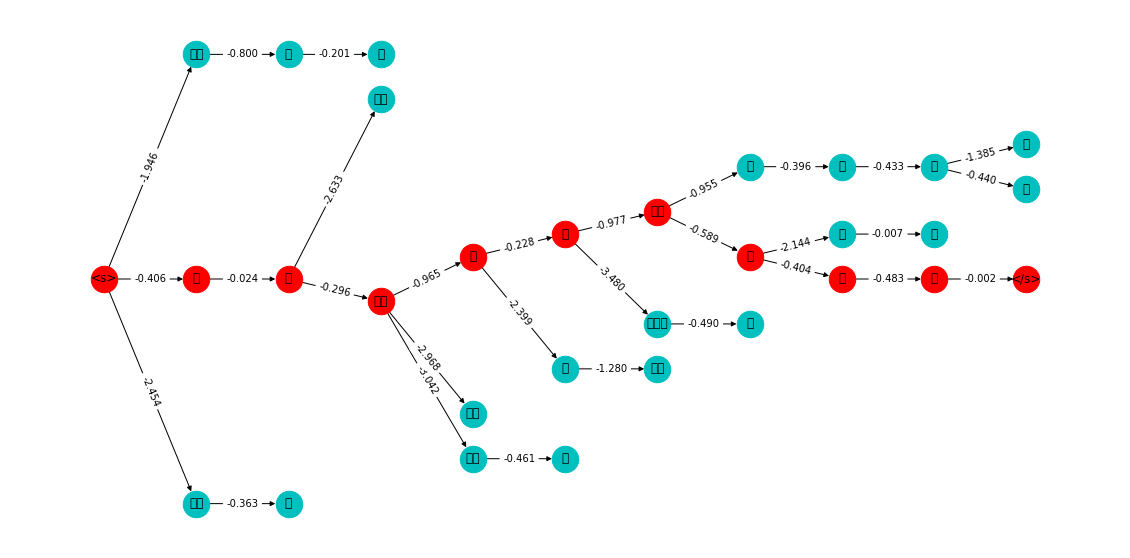

In [32]:
num = 0
parse_beam_search(y_pred[num], ll[num], link[num])

In [33]:
sess.close()